In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [659]:
def print_board(board):
    print(np.reshape(board, (3,3)))

def is_winning_board(board, winner = ['X', 'O']):
    
    ways_to_win = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]])

    i = 0
    check_win = False

    while(check_win is False and i < len(ways_to_win)):
        
        win_vec = ways_to_win[i]
        
        vals_x = [board[w]== "X" for w in win_vec]
        vals_o = [board[w]== "O" for w in win_vec]
        
        if winner == 'X':
            check_win = (sum(vals_x) == 3)
        elif winner == 'O':
            check_win = (sum(vals_o) == 3)
        else:
             check_win = (sum(vals_x) == 3) | (sum(vals_o) == 3)
            
        i = i + 1    

    return check_win

def is_almost_win(board, for_player = "X"):
    
    ways_to_win = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]])

    i = 0
    
    check_awin = False

    while(check_awin is False and i < len(ways_to_win)):
        
        j = 0
        
        win_vec = ways_to_win[i]
                        
        ways_to_almost_win = [win_vec[combo] for combo in [[0,1], [1,2], [0,2]]]
        
        while(check_awin is False and j < len(ways_to_almost_win)):
                            
            awin_vec = ways_to_almost_win[j] 
                        
            vals_player = [board[w] == for_player for w in awin_vec]
            
            vals_open = [board[w] == "" for w in win_vec]            
            
            check_awin = (sum(vals_player) == 2) and (sum(vals_open) == 1)
            
            j = j + 1
            
        i = i + 1    
                        
    how_to_win = ways_to_win[i-1]    
    
    if check_awin:
        which_play = how_to_win[np.where(np.array(board)[how_to_win] == "")[0][0]]
    else:
        which_play = []
    
    return which_play, check_awin

def is_full_board(board):
    return sum([board[i] in ["X", "O"] for i in range(9)]) == 9

def unique_boards(all_boards):
    return [np.array(x) for x in set(tuple(x) for x in all_boards)]

def get_baseline_value(board):
    
    if is_winning_board(board, winner = 'X'):
        return 1    
    elif is_winning_board(board, winner = 'O') or is_full_board(board):
        return 0
    else:
        return .5
    
def get_value_board(board, value_df):
    board_df = pd.DataFrame([board])
    return board_df.merge(value_df, how = "left")['value'].loc[0]

def baseline_value_table():

    round = 0
    player_turns = ['X', 'O', 'X', 'O', 'X', 'O', 'X', 'O', 'X']

    prev_round_boards = [np.array(["", "", "", "", "", "", "", "", ""])]

    all_boards = prev_round_boards

    while(round < 9):

        current_player = player_turns[round]
        round_boards = []

        for prev_board in prev_round_boards:

            if not is_winning_board(prev_board):
                still_open = np.where(prev_board == '')[0]

                for move in still_open:
                    new_board = prev_board.copy()
                    new_board[move] = current_player
                    round_boards = round_boards + [new_board]

        round_boards_unique = unique_boards(round_boards)

        prev_round_boards =  round_boards_unique

        all_boards = all_boards + round_boards_unique

        round = round + 1
        
        init_values = [get_baseline_value(board) for board in all_boards]

        value_df = pd.DataFrame(all_boards)

        all_boards_str = [','.join(board) for board in all_boards]

        value_df['board_str'] = all_boards_str

        value_df['value'] = init_values

    return value_df


Let the learner play 300 rounds of games against a random-selection oponent with decaying learning rate and epsilon in epsilon-greedy strategy.

$V(S_t) \leftarrow V(S_t) + \alpha[ V(S_{t+1}) - V(S_t)]$ 

For example, if $\alpha  = .1$ and $V(S_t) = .4$ and $V(S_{t+1})$ = .5, then $V(S_t)$ becomes 0.41.    

Epsilon = % of time the learner takes a random step
(otherwise it takes the move with the highest 

In [662]:
def learner_move(curr_board, epsilon, alpha, player = 'X'):

    curr_board_str = ','.join(curr_board)

    curr_board_value = get_value_board(curr_board, value_df)
    
    still_open = np.where(curr_board == '')[0]

    next_boards = []

    for move in still_open:
        next_board = curr_board.copy()
        next_board[move] = 'X'
        next_boards = next_boards + [next_board]

    greedy = np.random.random_sample() > epsilon

    values = [get_value_board(board, value_df) for board in next_boards]

    if greedy:
        choices = still_open[np.where(values == max(values))]
        if len(choices) > 1:
            next_move = np.random.choice(choices)
        else:
            next_move = choices[0]
    else:
        next_move = np.random.choice(still_open)

    new_board = curr_board.copy()
    new_board[next_move] = player

    new_board_value = get_value_board(new_board, value_df)

    curr_board_value  = curr_board_value + alpha*(new_board_value - curr_board_value)
    
    value_df.loc[value_df['board_str'] == curr_board_str, 'value'] = curr_board_value
    
    return new_board

# not being used
def random_move(curr_board, player = 'O'):
    still_open = np.where(curr_board == '')[0]

    next_move = np.random.choice(still_open)
    
    new_board = curr_board.copy()
    new_board[next_move] = player
    
    return new_board

def smartish_move(curr_board, player = 'O'):

    opponent = np.asscalar(np.where(player == "O", "X", "O"))
        
    me_best_move, me_win = is_almost_win(curr_board, for_player = player)
        
    op_best_move, op_win = is_almost_win(curr_board, for_player = opponent)
    
    # can I win? --> so win then
    if me_win:
        new_board = curr_board.copy()
        new_board[me_best_move] = player
        
    # is other player about to win? --> block them
    elif op_win:
        new_board = curr_board.copy()        
        new_board[op_best_move] = player
    
    # otherwise pick randomly
    else:
        still_open = np.where(np.array(curr_board) == '')[0]

        next_move = np.random.choice(still_open)

        new_board = curr_board.copy()
        new_board[next_move] = player

    return new_board

def make_move(curr_board, turn, epsilon, alpha, RL_player = 'X'):
    
    if turn in [0,2,4,6,8]:
        new_board = learner_move(curr_board, epsilon, alpha, player = RL_player)
        
    else:
        comp_player = np.asscalar(np.where(RL_player == 'X', 'O', 'X'))
        new_board = smartish_move(curr_board, player = comp_player)
        
    return new_board

def which_turns_value_changes(old_value_df, new_value_df):
    merge_df = old_value_df.merge(new_value_df, on = [0,1,2,3,4,5,6,7,8, 'board_str'], suffixes = ["_old", "_new"])
        
    changes_df = merge_df.loc[merge_df['value_old'] != merge_df['value_new']].reset_index(drop = True)
        
    def get_row_turn(data, row):
        return sum(data.loc[row][:9] != "")
        
    turns_changed = [get_row_turn(changes_df, row) for row in list(range(changes_df.shape[0]))]
    
    return turns_changed

def play_round(epsilon, alpha, show = False):
    
    old_value_df = value_df.copy()
    
    curr_board = np.array(['', '', '', '', '', '', '', '', ''])

    turn = 0

    check_win = False

    while(turn < 9 and check_win is False):
        
        new_board = make_move(curr_board, turn, epsilon, alpha)
        
        if show:
            print_board(new_board)

        x_wins = is_winning_board(new_board, 'X')
        o_wins = is_winning_board(new_board, 'O')

        check_win = x_wins or o_wins

        curr_board = new_board
        turn = turn + 1
        
    new_value_df = value_df.copy()
    
    turns_change = which_turns_value_changes(old_value_df, new_value_df)

    if x_wins:
        ending = "X wins"
    elif o_wins:
        ending = "O wins"
    else:
        ending = "cats"
        
    return curr_board, turns_change, ending

def play_all_rounds(alpha_list, epsilon_list):
    
    value_df = baseline_value_table()
    
    print(value_df.value.value_counts())
    
    num_epochs = len(alpha_list)
    
    win_list = []
    turns_list = []
    
    for i in range(num_epochs):
        if i % 500 == 0:
            print(i)
        
        end_board, turns_change, winner = play_round(epsilon_list[i], alpha_list[i])
        
        if len(turns_change) > 0:
            turns_list.append(turns_change)
        else:
            turns_list.append([-99])
            
        win_list = win_list + [winner]   
        
    return win_list, turns_list

In [661]:
value_df = baseline_value_table()

value_df.shape

(5478, 11)

In [664]:
epsilon_list = np.arange(1, .1, -.0001)
alpha_list = np.array([.3] * len(epsilon_list))

wins, turns = play_all_rounds(alpha_list, epsilon_list)

   iter_group  ending  count_val ending_cat
0           0  O wins         16     O wins
1           0    cats          3       cats
2           0  X wins          1     X wins
3          20  O wins         14     O wins
4          20    cats          5       cats


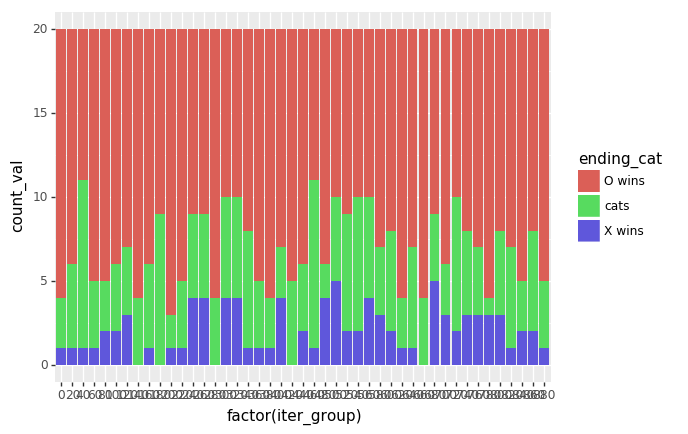

<ggplot: (-9223372029299371113)>

In [544]:
wins_df = pd.DataFrame({'ending':wins})

wins_df['iter'] = range(wins_df.shape[0])

wins_df['iter_group'] = wins_df['iter'].apply(lambda num: num - (num % 20))

wins_df_group = wins_df.groupby('iter_group')['ending'].value_counts().rename(columns = {'': ''}).reset_index().rename(columns = {0:'count_val'})

wins_df_group['ending_cat'] = pd.Categorical(wins_df_group['ending'], categories = ['O wins', 'cats', 'X wins'], ordered = True)

print(wins_df_group.head())

(p9.ggplot(wins_df_group, p9.aes(x = 'factor(iter_group)', fill = 'ending_cat', y = 'count_val')) + 
p9.geom_col()
)

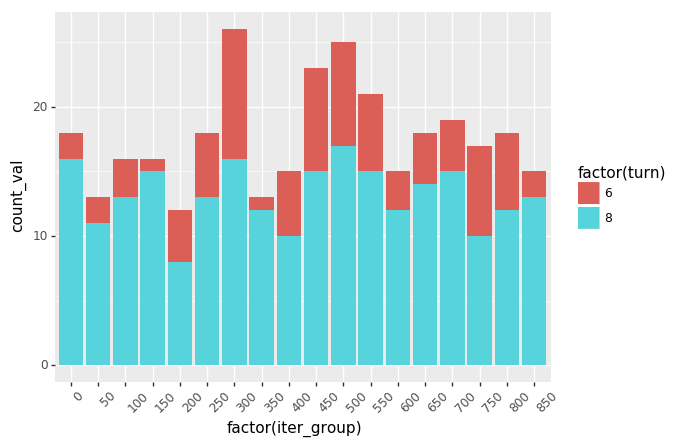

<ggplot: (7555285126)>

In [628]:
turns_df = pd.DataFrame([[i, val] for i in range(len(turns)) for val in turns[i]], columns = ['iter', 'turn'])

turns_df['iter_group'] = turns_df['iter'].apply(lambda num: num - (num % 50))

turns_df_group = turns_df.groupby('iter_group')['turn'].value_counts().rename(columns = {'': ''}).reset_index().rename(columns = {0:'count_val'})

turns_df_group_lim = turns_df_group.loc[turns_df_group['turn'] != -99]

(p9.ggplot(turns_df_group_lim, p9.aes(x = 'factor(iter_group)', y = 'count_val', fill = 'factor(turn)')) + 
p9.geom_col() +
p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=0))
)

(141, 11)


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 6'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


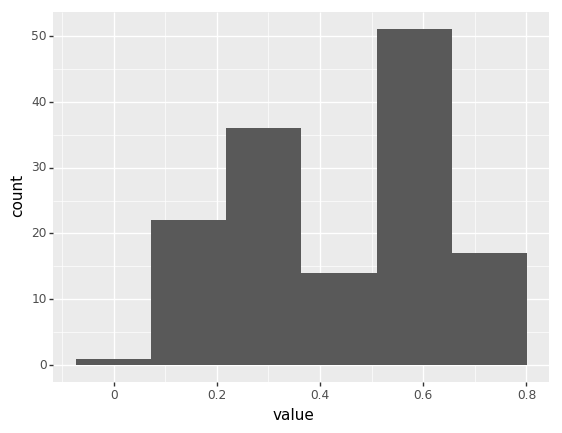

<ggplot: (7556615460)>

In [563]:
new_values = value_df.loc[~value_df['value'].isin([0, 0.5, 1])]

print(new_values.shape)

p9.ggplot(new_values, p9.aes(x = 'value')) + p9.geom_histogram()

In [641]:
value_df = baseline_value_table()

value_df.value.value_counts()

0.5    4520
1.0     626
0.0     332
Name: value, dtype: int64

In [655]:
play_round(.5, .2, show = True)

[['X' '' '']
 ['' '' '']
 ['' '' '']]
[['X' '' '']
 ['' '' '']
 ['O' '' '']]
[['X' '' '']
 ['' '' 'X']
 ['O' '' '']]
[['X' '' 'O']
 ['' '' 'X']
 ['O' '' '']]
[['X' '' 'O']
 ['X' '' 'X']
 ['O' '' '']]
[['X' '' 'O']
 ['X' 'O' 'X']
 ['O' '' '']]


(array(['X', '', 'O', 'X', 'O', 'X', 'O', '', ''], dtype='<U1'), [], 'O wins')

In [656]:
value_df.value.value_counts()

0.5    4516
1.0     626
0.0     332
0.6       2
0.4       2
Name: value, dtype: int64

In [572]:
value_df.to_csv("baseline_values.csv")

In [616]:
value_df.head(50)


,0,1,2,3,4,5,6,7,8,board_str,value
0,,,,,,,,,,",,,,,,,,",0.5
1,X,,,,,,,,,"X,,,,,,,,",0.5
2,,,,,X,,,,,",,,,X,,,,",0.5
3,,,,,,,X,,,",,,,,,X,,",0.5
4,,,,,,,,,X,",,,,,,,,X",0.5
5,,,,,,,,X,,",,,,,,,X,",0.5
6,,,,X,,,,,,",,,X,,,,,",0.5
7,,,X,,,,,,,",,X,,,,,,",0.5
8,,,,,,X,,,,",,,,,X,,,",0.5
9,,X,,,,,,,,",X,,,,,,,",0.5


In [618]:
value_df.loc[value_df['board_str'] == ',O,,X,O,X,O,,X']

,0,1,2,3,4,5,6,7,8,board_str,value
3497,,O,,X,O,X,O,,X,",O,,X,O,X,O,,X",0.6


In [637]:
def get_baseline_value(board):
    
    if is_winning_board(board, winner = 'X'):
        return 1    
    elif is_winning_board(board, winner = 'O') or is_full_board(board):
        return 0
    else:
        return .5
    
    
get_baseline_value(['O', 'O', 'O', 'X', 'X', 'O', 'X', 'X', ''])

0.5

In [639]:
is_winning_board(['O', 'O', 'O', 'X', 'X', 'O', 'X', 'X', ''], winner = 'O')

True